In [ ]:
import sys
!{sys.executable} -m pip install deap

gen	nevals	avg     	min     	max     
0  	50    	0.766154	0.707692	0.830769


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


1  	42    	0.781231	0.723077	0.830769
2  	43    	0.789846	0.738462	0.830769
3  	35    	0.802154	0.738462	0.830769
4  	42    	0.807692	0.738462	0.830769
5  	36    	0.812   	0.707692	0.830769
6  	46    	0.818154	0.738462	0.830769
7  	34    	0.825846	0.738462	0.830769
8  	41    	0.827692	0.784615	0.830769
9  	35    	0.827077	0.753846	0.830769
10 	36    	0.826462	0.769231	0.830769
11 	35    	0.827692	0.8     	0.830769
12 	42    	0.828615	0.769231	0.830769
13 	41    	0.824615	0.738462	0.830769
14 	42    	0.824923	0.738462	0.830769
15 	36    	0.827692	0.769231	0.830769
16 	34    	0.830769	0.830769	0.830769
17 	38    	0.828615	0.784615	0.830769
18 	39    	0.826462	0.723077	0.830769
19 	39    	0.822462	0.753846	0.830769
20 	29    	0.826769	0.738462	0.830769
Best ranked features:  [0, 9, 12]
Accuracy:  0.8307692307692308
              precision    recall  f1-score   support

           0       0.79      0.97      0.87        39
           1       0.94      0.62      0.74        26

    accuracy

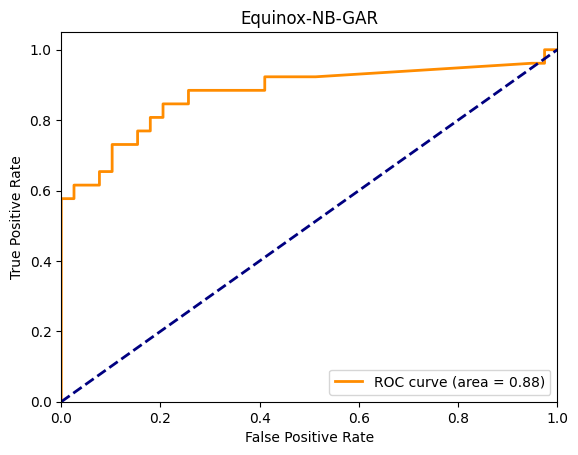

In [4]:
import sys
!{sys.executable} -m pip install deap
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer  # For handling NaNs
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report
from deap import base, creator, tools, algorithms
import random
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Load the data
data = pd.read_csv('equinox.csv')

# Convert 'bugs' column to binary (assuming 0 means no bug, and >0 means there's a bug)
data['bugs_binary'] = data['bugs'].apply(lambda x: 1 if x > 0 else 0)

# Pre-process the data
columns_to_drop = ['classname', 'bugs', 'nonTrivialBugs', 'majorBugs', 'criticalBugs', 'highPriorityBugs', 'bugs_binary']
X = data.drop(columns=columns_to_drop)
y = data['bugs_binary']

# Handle NaN values
X = X.dropna(axis=1, how='all')
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X))
X_imputed.columns = X.columns
X_imputed.index = X.index
X = X_imputed

# Ensure all values are non-negative
negative_features = X.columns[(X < 0).any()]
X = X.drop(columns=negative_features)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Evaluation function for ranking
def evalMetricRanking(individual):
    X_train_ordered = X_train.iloc[:, individual]
    X_test_ordered = X_test.iloc[:, individual]
    
    # For demonstration, just using first three ordered features for evaluation
    X_train_selected = X_train_ordered.iloc[:, :3]
    X_test_selected = X_test_ordered.iloc[:, :3]
    
    clf = GaussianNB()
    clf.fit(X_train_selected, y_train)
    y_pred = clf.predict(X_test_selected)
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy,

# Setting up the Genetic Algorithm
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
N_FEATURES = X_train.shape[1]
toolbox.register("indices", random.sample, range(N_FEATURES), N_FEATURES)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", tools.cxPartialyMatched)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evalMetricRanking)

pop = toolbox.population(n=50)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)
algorithms.eaSimple(pop, toolbox, cxpb=0.7, mutpb=0.2, ngen=20, stats=stats, halloffame=hof, verbose=True)

best_ranking = hof[0]
selected_features = best_ranking[:3]
print("Best ranked features: ", selected_features)

X_train_selected = X_train.iloc[:, selected_features]
X_test_selected = X_test.iloc[:, selected_features]

clf = GaussianNB()
clf.fit(X_train_selected, y_train)

y_pred = clf.predict(X_test_selected)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

y_pred_proba = clf.predict_proba(X_test_selected)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

df = pd.DataFrame({
    'AUC': [roc_auc],
    'FPR': [fpr],
    'TPR': [tpr]
})
df.to_csv('./AUC_Extracts/Equinox/Equinox_NB_GAR.csv', index=False)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Equinox-NB-GAR')
plt.legend(loc="lower right")
plt.show()